<font size='5'>Variational Bayes - Sampling the generative model</font>

In variational inference applied to time series data, we choose M clusters each with distinct parameters allowing computation of a likelihood function for any time step. The likelihood function output given the empirical data observed at any time step varies depending on our chosen parameters for each of the M clusters that any time step may fall into. The model optimizes the parameters of the M clusters to maximize the likelihood of those parameters given the data.

In practice this works out to function as an unsupervised classification algorithm for the most likely distribution (mean and covariance) a time step comes from. This is applicable to discovering market regimes in quantitative finance. This notebook is purely an exercise in demonstration of scikit-learn's Bayesian optimization capabilities in this setting.

This variant of the notebook will sample from the posterior distribution over the parameters of the latent states, and their transition matrix that gives us a probability of switching to any given state based on the empirically observed data.

In [118]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 

import sklearn 
import sklearn.mixture as mix 

Testing a small universe of the 10Y Treasury, a Commodity ETF, and Tech ETF. The goal will be time series clustering using variational inference. There are periods of time (regimes) where certain assets outperform the others and their precise relationship is captured by the latent state. 

Set num_components to a very high number so the data is fit in a non-parametric way where we need not know the number of clusters in advance. 

In [119]:
assetlist = [ 'IEF', 'GSG', 'IXN' ]
num_components = 99

Create the subset of assets.

In [120]:
m6 = pd.read_csv('./data/assets_m6.csv')
m6_assets = pd.DataFrame()

for sym in assetlist: 
    m6_assets[sym] = m6[m6['symbol'] == sym]['price'].values

Formatting the training data. 1st-order differencing of the log price for each asset. View auto-correlation.

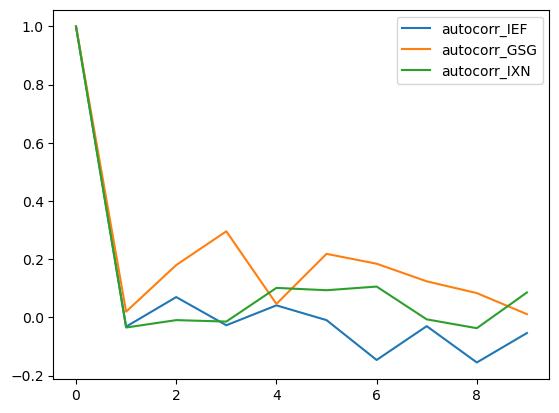

In [121]:
m6_subset = m6_assets.copy().apply(np.log).apply(np.diff)
m6_subset = m6_subset.dropna().reset_index().drop(columns='index')

autocorr_df = pd.DataFrame()
autocorr_df['decay_IEF'] = m6_subset['IEF'].apply(abs)
autocorr_df['decay_GSG'] = m6_subset['GSG'].apply(abs) 
autocorr_df['decay_IXN'] = m6_subset['IXN'].apply(abs) 
decay_func = lambda S, _range: [S.autocorr(lag=Lag) for Lag in _range]

sns.lineplot(data=decay_func(autocorr_df['decay_IEF'], range(0, 10)), label='autocorr_IEF') 
sns.lineplot(data=decay_func(autocorr_df['decay_GSG'], range(0, 10)), label='autocorr_GSG')
sns.lineplot(data=decay_func(autocorr_df['decay_IXN'], range(0, 10)), label='autocorr_IXN')
plt.show()

Instantiate a non-parametric clustering model using the dirichlet process. 

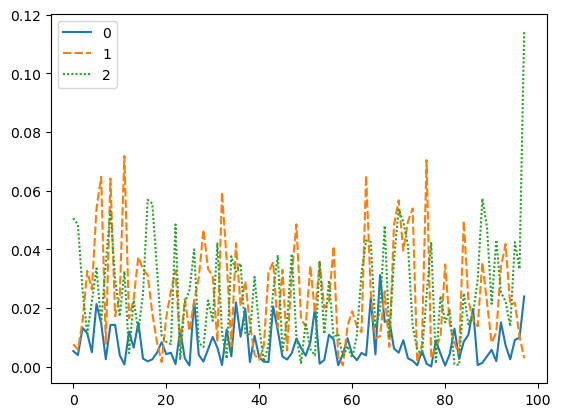

In [122]:
walkforward_results = [] 
residuals = []

local_model = mix.BayesianGaussianMixture(n_components=num_components, weight_concentration_prior_type='dirichlet_process', warm_start=True)

for w in range(num_components, len(m6_subset) - 1):
    
    local_model = local_model.fit(m6_subset[:w])
    sample, y = local_model.sample(1)

    walkforward_results.append(sample[0]) 
    
    ief=abs(sample[0][0] - (m6_subset.iloc[w]['IEF']))
    gsg=abs(sample[0][1] - (m6_subset.iloc[w]['GSG']))
    ixn=abs(sample[0][2] - (m6_subset.iloc[w]['IXN']))

    residuals.append([ ief, gsg, ixn ])

get_col = lambda sampler, M: [ s[M] for s in sampler ]

df = pd.DataFrame()
df['0']=get_col(residuals, 0)
df['1']=get_col(residuals, 1)
df['2']=get_col(residuals, 2)

sns.lineplot(data=df)
plt.show()

          IEF       GSG       IXN
99  -0.003546  0.015222  0.034585
100 -0.009199  0.019828  0.028099
101 -0.007905  0.031869 -0.000648
102  0.000099  0.013542 -0.001080
103  0.007754 -0.015890 -0.013476
..        ...       ...       ...
193 -0.077446 -0.027648 -0.049341
194 -0.070808 -0.044878 -0.037840
195 -0.067399 -0.071980 -0.061664
196 -0.045208 -0.063772  0.016911
197 -0.047290 -0.045770  0.039370

[99 rows x 3 columns]


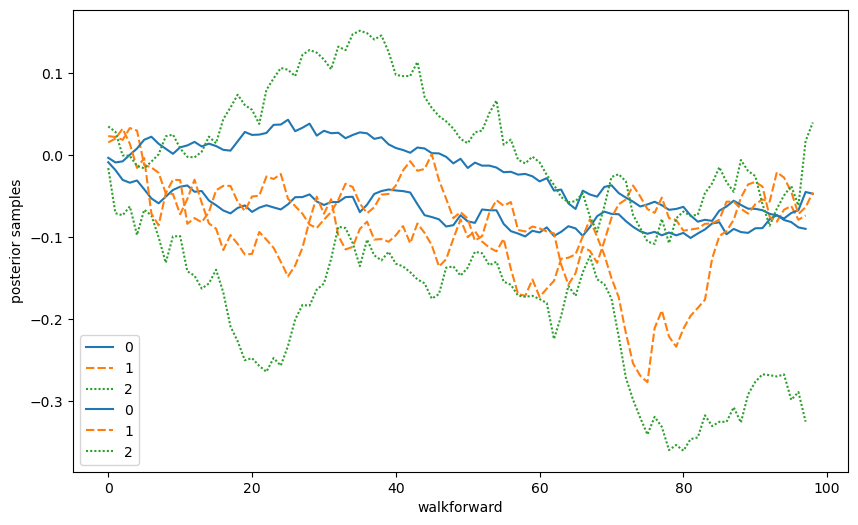

In [123]:
fig,ax = plt.subplots(figsize=(10, 6))
 
df_pst = pd.DataFrame()
df_pst['IEF_sampled']=get_col(walkforward_results, 0)
df_pst['GSG_sampled']=get_col(walkforward_results, 1)
df_pst['IXN_sampled']=get_col(walkforward_results, 2)
print(m6_subset[num_components:].cumsum())

sns.lineplot(data=df_pst.cumsum().values,ax=ax)
sns.lineplot(data=m6_subset[num_components:].cumsum().values,ax=ax)
ax.set_ylabel('posterior samples')
ax.set_xlabel('walkforward')
plt.show()